<a href="https://colab.research.google.com/github/bhoomireddyvijayakumari/Shopper-Spectrum-Customer-Segmentation-and-Product-Recommendations-in-E-Commerce/blob/main/shoppers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project: Shopper Spectrum - Customer Segmentation and Product Recommendation**  



##### **Project Type**    - EDA/Regression
##### **Contribution**    - Individual


# **Project Summary -**

This project focuses on analyzing customer purchasing behavior from an e-commerce dataset using a combination of RFM (Recency, Frequency, Monetary) analysis, unsupervised machine learning, and a product recommendation system. The goal is to segment customers into meaningful groups to enable more targeted marketing strategies and build a simple yet effective recommendation engine to enhance the customer shopping experience.
The dataset contains transaction records with invoice details, product descriptions, quantities, prices, timestamps, and customer IDs. The initial phase of the project involved extensive data cleaning:

- Removal of null values (particularly missing CustomerIDs),
- Elimination of canceled transactions (indicated by negative quantities),
- Derivation of a new Amount column calculated as Quantity × UnitPrice.

The RFM framework was used to summarize each customer's engagement:
- Recency: How recently a customer made a purchase.
- Frequency: How often a customer made purchases.
- Monetary: How much a customer has spent.

Once the RFM table was generated, the values were standardized to prepare them for clustering. KMeans clustering was employed to segment the customers. The optimal number of clusters was determined to be 3, using both the Elbow Method and Silhouette Score for validation.
The resulting customer segments were:

- Cluster 0 – High-value, loyal customers: They purchase frequently, spend  the most, and have shopped recently. These are the most valuable customers.
- Cluster 1 – Inactive or at-risk customers: They haven’t purchased recently and have low frequency and spending. These users are likely to churn or already disengaged.
- Cluster 2 – Moderate or new customers: They exhibit mid-level engagement and spending behavior, showing potential to become loyal customers with the right nurturing.

To visualize the clustering results, PCA (Principal Component Analysis) was applied to reduce the 3D RFM space into two dimensions. This helped clearly distinguish customer groups and understand their distribution.

In the second part of the project, an item-based collaborative filtering recommendation system was implemented. Using a user-item matrix and cosine similarity, the system calculates how similar each product is to others based on co-purchase patterns. A function get_recommendations(product_name) was created, which returns the top 10 similar products for any given input item. This recommendation engine can help businesses improve user engagement and sales by offering relevant suggestions based on historical purchasing behavior.

# **GitHub Link -**

https://github.com/bhoomireddyvijayakumari/Shopper-Spectrum-Customer-Segmentation-and-Product-Recommendations-in-E-Commerce.git

# **Problem Statement**
The global e-commerce industry generates vast amounts of transaction data daily, offering valuable insights into customer purchasing behaviors. Analyzing this data is essential for identifying meaningful customer segments and recommending relevant products to enhance customer experience and drive business growth. This project aims to examine transaction data from an online retail business to uncover patterns in customer purchase behavior, segment customers based on Recency, Frequency, and Monetary (RFM) analysis, and develop a product recommendation system using collaborative filtering techniques

# **Let's Begin!!!**

# 1. Know Your Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import joblib
import os

# Dataset Loading

In [84]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/SSS/online_retail.csv')
df.shape

(541909, 8)

In [85]:
print("\n Column Information:")
print("=" * 50)
print(df.info())


 Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None


In [86]:
print("\ First 5 rows:")
print("=" * 50)
print(df.head())

\ First 5 rows:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

           InvoiceDate  UnitPrice  CustomerID         Country  
0  2022-12-01 08:26:00       2.55     17850.0  United Kingdom  
1  2022-12-01 08:26:00       3.39     17850.0  United Kingdom  
2  2022-12-01 08:26:00       2.75     17850.0  United Kingdom  
3  2022-12-01 08:26:00       3.39     17850.0  United Kingdom  
4  2022-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [87]:
# Check for missing values
print("\n Missing Values Analysis:")
print("=" * 50)
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Percentage': missing_percent
}).sort_values('Missing Count', ascending=False)
print(missing_df[missing_df['Missing Count'] > 0])



 Missing Values Analysis:
             Missing Count  Percentage
CustomerID          135080   24.926694
Description           1454    0.268311


In [88]:
# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\n Duplicate rows: {duplicates:,}")
# Basic statistics for numerical columns
print("\n Numerical Columns Statistics:")
print("=" * 50)
print(df.describe())


 Duplicate rows: 5,268

 Numerical Columns Statistics:
            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000


In [89]:
print("\n Unique Values Analysis:")
print("=" * 50)
print(f"Unique Countries: {df['Country'].nunique()}")
print(f"Unique Customers: {df['CustomerID'].nunique()}")
print(f"Unique Products: {df['StockCode'].nunique()}")
print(f"Unique Invoices: {df['InvoiceNo'].nunique()}")


 Unique Values Analysis:
Unique Countries: 38
Unique Customers: 4372
Unique Products: 4070
Unique Invoices: 25900


In [90]:
df_clean = df.copy()
#  Remove rows with missing CustomerID
print("\n Removing rows with missing CustomerID...")
before_customer = len(df_clean)
df_clean = df_clean.dropna(subset=['CustomerID'])
after_customer = len(df_clean)
removed_customers = before_customer - after_customer
print(f"   Removed {removed_customers:,} rows with missing CustomerID")
print(f"   Remaining rows: {after_customer:,}")



 Removing rows with missing CustomerID...
   Removed 135,080 rows with missing CustomerID
   Remaining rows: 406,829


In [91]:
#  Exclude cancelled invoices (InvoiceNo starting with 'C')
print("\n Excluding cancelled invoices...")
before_cancel = len(df_clean)
df_clean = df_clean[~df_clean['InvoiceNo'].astype(str).str.startswith('C')]
after_cancel = len(df_clean)
removed_cancelled = before_cancel - after_cancel
print(f"   Removed {removed_cancelled:,} cancelled invoices")
print(f"   Remaining rows: {after_cancel:,}")



 Excluding cancelled invoices...
   Removed 8,905 cancelled invoices
   Remaining rows: 397,924


In [92]:
#  Remove negative or zero quantities and prices
print("\n Removing negative/zero quantities and prices...")
before_quantity = len(df_clean)
print(f"   Before filtering - Rows: {before_quantity:,}")
print(f"   Quantity range: {df_clean['Quantity'].min()} to {df_clean['Quantity'].max()}")
print(f"   UnitPrice range: {df_clean['UnitPrice'].min()} to {df_clean['UnitPrice'].max()}")

df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]
after_quantity = len(df_clean)
removed_invalid = before_quantity - after_quantity
print(f"   Removed {removed_invalid:,} rows with invalid quantities/prices")
print(f"   Remaining rows: {after_quantity:,}")



 Removing negative/zero quantities and prices...
   Before filtering - Rows: 397,924
   Quantity range: 1 to 80995
   UnitPrice range: 0.0 to 8142.75
   Removed 40 rows with invalid quantities/prices
   Remaining rows: 397,884


In [93]:
#  Convert InvoiceDate to datetime
print("\n Converting InvoiceDate to datetime...")
print(f"   Original InvoiceDate type: {df_clean['InvoiceDate'].dtype}")
print(f"   Sample dates: {df_clean['InvoiceDate'].head().tolist()}")

df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
print(f"   Converted InvoiceDate type: {df_clean['InvoiceDate'].dtype}")
print(f"   Date range: {df_clean['InvoiceDate'].min()} to {df_clean['InvoiceDate'].max()}")



 Converting InvoiceDate to datetime...
   Original InvoiceDate type: object
   Sample dates: ['2022-12-01 08:26:00', '2022-12-01 08:26:00', '2022-12-01 08:26:00', '2022-12-01 08:26:00', '2022-12-01 08:26:00']
   Converted InvoiceDate type: datetime64[ns]
   Date range: 2022-12-01 08:26:00 to 2023-12-09 12:50:00


In [94]:
# Create additional features
print("\n Creating additional features...")
df_clean['TotalAmount'] = df_clean['Quantity'] * df_clean['UnitPrice']
df_clean['Year'] = df_clean['InvoiceDate'].dt.year
df_clean['Month'] = df_clean['InvoiceDate'].dt.month
df_clean['DayOfWeek'] = df_clean['InvoiceDate'].dt.day_name()
df_clean['Hour'] = df_clean['InvoiceDate'].dt.hour

print(f"   Created TotalAmount: Range ${df_clean['TotalAmount'].min():.2f} to ${df_clean['TotalAmount'].max():.2f}")
print(f"   Years in data: {sorted(df_clean['Year'].unique())}")
print(f"   Months in data: {sorted(df_clean['Month'].unique())}")



 Creating additional features...
   Created TotalAmount: Range $0.00 to $168469.60
   Years in data: [np.int32(2022), np.int32(2023)]
   Months in data: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12)]


In [95]:
#  Clean product descriptions
print("\nCleaning product descriptions...")
missing_descriptions = df_clean['Description'].isnull().sum()
print(f"   Missing descriptions: {missing_descriptions:,}")

df_clean['Description'] = df_clean['Description'].fillna('Unknown Product')
df_clean['Description'] = df_clean['Description'].str.strip().str.upper()

print(f"   Sample cleaned descriptions:")
print(f"   {df_clean['Description'].head().tolist()}")



Cleaning product descriptions...
   Missing descriptions: 0
   Sample cleaned descriptions:
   ['WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE METAL LANTERN', 'CREAM CUPID HEARTS COAT HANGER', 'KNITTED UNION FLAG HOT WATER BOTTLE', 'RED WOOLLY HOTTIE WHITE HEART.']


In [96]:
# Convert CustomerID to integer
print("\n Converting CustomerID to integer...")
print(f"   Original CustomerID type: {df_clean['CustomerID'].dtype}")
df_clean['CustomerID'] = df_clean['CustomerID'].astype(int)
print(f"   Converted CustomerID type: {df_clean['CustomerID'].dtype}")

print(f"Final dataset shape: {df_clean.shape}")
data_removed_percent = ((len(df) - len(df_clean)) / len(df) * 100)
print(f"Data quality improvement: {data_removed_percent:.2f}% of problematic data removed")



 Converting CustomerID to integer...
   Original CustomerID type: float64
   Converted CustomerID type: int64
Final dataset shape: (397884, 13)
Data quality improvement: 26.58% of problematic data removed


# **2. Exploratory Data Analysis (EDA)**


 Analyzing transaction volume by country...
Top 5 countries by transaction volume:
Country
United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Name: count, dtype: int64


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'United Kingdom'),
  Text(1, 0, 'Germany'),
  Text(2, 0, 'France'),
  Text(3, 0, 'EIRE'),
  Text(4, 0, 'Spain'),
  Text(5, 0, 'Netherlands'),
  Text(6, 0, 'Belgium'),
  Text(7, 0, 'Switzerland'),
  Text(8, 0, 'Portugal'),
  Text(9, 0, 'Australia')])

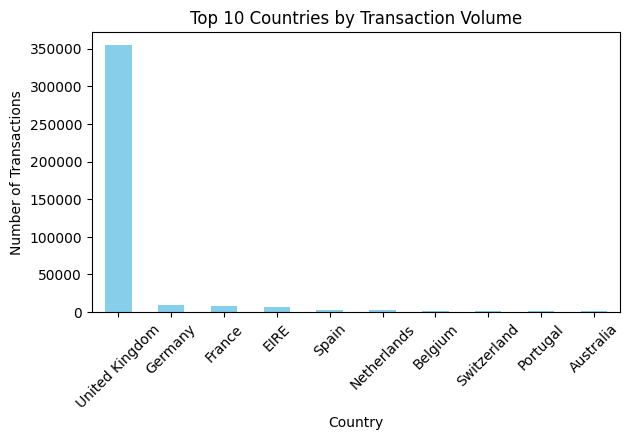

In [97]:
os.makedirs('figures', exist_ok=True)
#  Transaction volume by country
print("\n Analyzing transaction volume by country...")

plt.figure(figsize=(15, 8))
country_transactions = df_clean['Country'].value_counts().head(10)
print(f"Top 5 countries by transaction volume:")
print(country_transactions.head())

plt.subplot(2, 2, 1)
country_transactions.plot(kind='bar', color='skyblue')
plt.title('Top 10 Countries by Transaction Volume')
plt.xlabel('Country')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)

#Insights

Most transactions originate from the UK, suggesting it is the platform’s primary market.

UK dominates: 354,321 (≈89%) of transactions in the UK.
Other top countries: Germany, France, Ireland, Spain.


 Identifying top-selling products...
Top 5 best-selling products:
Description
PAPER CRAFT , LITTLE BIRDIE           80995
MEDIUM CERAMIC TOP STORAGE JAR        77916
WORLD WAR 2 GLIDERS ASSTD DESIGNS     54415
JUMBO BAG RED RETROSPOT               46181
WHITE HANGING HEART T-LIGHT HOLDER    36725
Name: Quantity, dtype: int64


Text(0.5, 0, 'Total Quantity Sold')

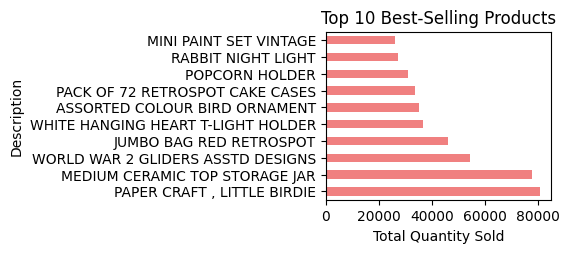

In [98]:
#  Top-selling products
print("\n Identifying top-selling products...")

plt.subplot(2, 2, 2)
top_products = df_clean.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
print(f"Top 5 best-selling products:")
print(top_products.head())

top_products.plot(kind='barh', color='lightcoral')
plt.title('Top 10 Best-Selling Products')
plt.xlabel('Total Quantity Sold')


#Insights

- Paper Craft, Little Birdie: 80,995 units (most sold).
- Medium Ceramic Top Storage Jar: 77,916 units.
- Generally, home décor, storage, lighting, and gift items are top.


 Visualizing purchase trends over time...
Monthly sales summary:
   Total months: 13
   Average monthly sales: $685,492.92
   Highest month: $1,161,817.38
   Lowest month: $447,137.35


(array([636]), [Text(636, 0, 'Jan\n2023')])

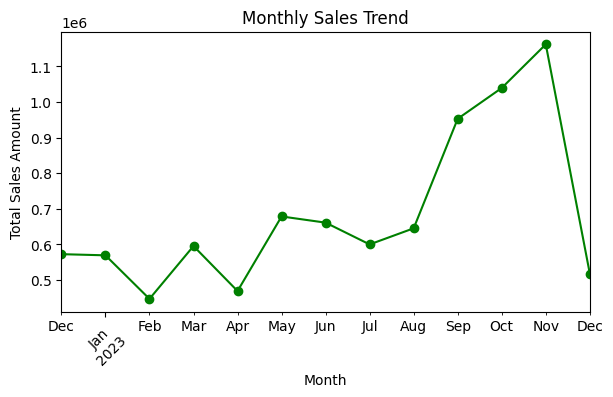

In [101]:
# Purchase trends over time
print("\n Visualizing purchase trends over time...")
plt.figure(figsize=(15,8))
plt.subplot(2, 2, 3)
monthly_sales = df_clean.groupby(df_clean['InvoiceDate'].dt.to_period('M'))['TotalAmount'].sum()
print(f"Monthly sales summary:")
print(f"   Total months: {len(monthly_sales)}")
print(f"   Average monthly sales: ${monthly_sales.mean():,.2f}")
print(f"   Highest month: ${monthly_sales.max():,.2f}")
print(f"   Lowest month: ${monthly_sales.min():,.2f}")

monthly_sales.plot(kind='line', marker='o', color='green')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales Amount')
plt.xticks(rotation=45)

#Insights

Monthly sales trend (last 13 months):
- Highest month: $1,161,817 (Nov 2023)

- Lowest month: $447,137 (Feb 2023)

- Insight: Significant seasonality; post-holiday sales drop.



 Analyzing customer spending distribution...
Customer spending statistics:
   Total customers: 4,338
   Average spending per customer: $2054.27
   Median spending per customer: $674.49
   Top spender: $280,206.02


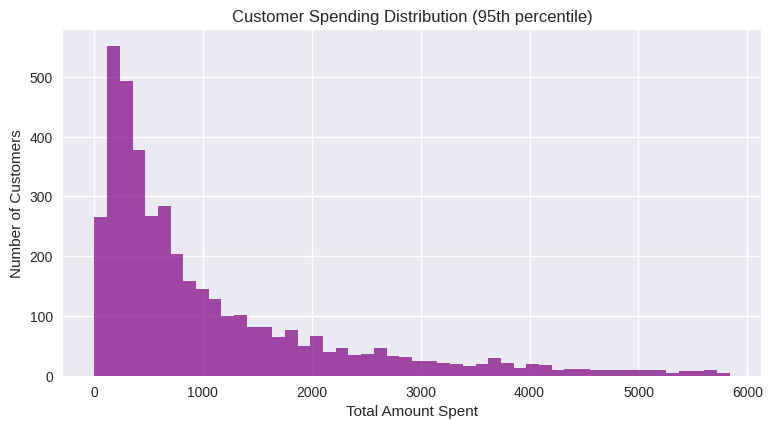

In [106]:
# Customer spending distribution
print("\n Analyzing customer spending distribution...")
plt.figure(figsize=(15,8))
plt.subplot(2, 2, 4)
customer_spending = df_clean.groupby('CustomerID')['TotalAmount'].sum()
print(f"Customer spending statistics:")
print(f"   Total customers: {len(customer_spending):,}")
print(f"   Average spending per customer: ${customer_spending.mean():.2f}")
print(f"   Median spending per customer: ${customer_spending.median():.2f}")
print(f"   Top spender: ${customer_spending.max():,.2f}")

# Plot histogram excluding top 5% outliers for better visualization
spending_95th = customer_spending.quantile(0.95)
filtered_spending = customer_spending[customer_spending < spending_95th]
plt.hist(filtered_spending, bins=50, color='purple', alpha=0.7)
plt.title('Customer Spending Distribution (95th percentile)')
plt.xlabel('Total Amount Spent')
plt.ylabel('Number of Customers')

plt.tight_layout()
plt.show()

#Insights

Distribution is highly skewed: A small percentage accounts for a large portion of sales.


In [107]:
print("\n Key Business Insights:")
print("=" * 50)
total_countries = df_clean['Country'].nunique()
total_products = df_clean['StockCode'].nunique()
total_customers = df_clean['CustomerID'].nunique()
total_revenue = df_clean['TotalAmount'].sum()
date_range_start = df_clean['InvoiceDate'].min()
date_range_end = df_clean['InvoiceDate'].max()
avg_order_value = df_clean.groupby('InvoiceNo')['TotalAmount'].sum().mean()

print(f" Total countries served: {total_countries}")
print(f" Total unique products: {total_products}")
print(f" Total unique customers: {total_customers}")
print(f" Total revenue: ${total_revenue:,.2f}")
print(f" Date range: {date_range_start} to {date_range_end}")
print(f" Average order value: ${avg_order_value:.2f}")

# Additional analysis
print(f"\n Additional Insights:")
print(f" Total unique invoices: {df_clean['InvoiceNo'].nunique():,}")
print(f" Total items sold: {df_clean['Quantity'].sum():,}")
print(f" Average items per transaction: {df_clean['Quantity'].mean():.2f}")
print(f" Average unit price: ${df_clean['UnitPrice'].mean():.2f}")



 Key Business Insights:
 Total countries served: 37
 Total unique products: 3665
 Total unique customers: 4338
 Total revenue: $8,911,407.90
 Date range: 2022-12-01 08:26:00 to 2023-12-09 12:50:00
 Average order value: $480.87

 Additional Insights:
 Total unique invoices: 18,532
 Total items sold: 5,167,812
 Average items per transaction: 12.99
 Average unit price: $3.12


#3. Feature Engineering

In [110]:
# Define the latest date in the dataset as reference point
latest_date = df_clean['InvoiceDate'].max()
print(f"Reference date (latest in dataset): {latest_date}")
# Calculate RFM metrics for each customer
print("\n Calculating RFM metrics...")

# Recency: Days since last purchase
print("   Calculating Recency...")
customer_last_purchase = df_clean.groupby('CustomerID')['InvoiceDate'].max()
recency_data = (latest_date - customer_last_purchase).dt.days

# Frequency: Number of unique transactions per customer
print("   Calculating Frequency...")
frequency_data = df_clean.groupby('CustomerID')['InvoiceNo'].nunique()

# Monetary: Total amount spent by customer
print("   Calculating Monetary...")
monetary_data = df_clean.groupby('CustomerID')['TotalAmount'].sum()
# Combine into RFM dataframe
rfm_data = pd.DataFrame({
    'CustomerID': recency_data.index,
    'Recency': recency_data.values,
    'Frequency': frequency_data.values,
    'Monetary': monetary_data.values
}).reset_index(drop=True)

print(f" RFM features calculated for {len(rfm_data)} customers")


Reference date (latest in dataset): 2023-12-09 12:50:00

 Calculating RFM metrics...
   Calculating Recency...
   Calculating Frequency...
   Calculating Monetary...
 RFM features calculated for 4338 customers


In [111]:
print("\n RFM Features Statistics:")
print("=" * 50)
print(rfm_data.describe())



 RFM Features Statistics:
         CustomerID      Recency    Frequency       Monetary
count   4338.000000  4338.000000  4338.000000    4338.000000
mean   15300.408022    91.536422     4.272015    2054.266460
std     1721.808492   100.014169     7.697998    8989.230441
min    12346.000000     0.000000     1.000000       3.750000
25%    13813.250000    17.000000     1.000000     307.415000
50%    15299.500000    50.000000     2.000000     674.485000
75%    16778.750000   141.000000     5.000000    1661.740000
max    18287.000000   373.000000   209.000000  280206.020000


In [112]:
# Analyze RFM distributions
print("\n RFM Distribution Analysis:")
print("=" * 50)
print(f"Recency (days since last purchase):")
print(f"   Min: {rfm_data['Recency'].min()} days")
print(f"   Max: {rfm_data['Recency'].max()} days")
print(f"   Mean: {rfm_data['Recency'].mean():.1f} days")
print(f"   Customers who purchased in last 30 days: {(rfm_data['Recency'] <= 30).sum():,}")

print(f"\nFrequency (number of purchases):")
print(f"   Min: {rfm_data['Frequency'].min()} purchases")
print(f"   Max: {rfm_data['Frequency'].max()} purchases")
print(f"   Mean: {rfm_data['Frequency'].mean():.1f} purchases")
print(f"   Customers with 5+ purchases: {(rfm_data['Frequency'] >= 5).sum():,}")

print(f"\nMonetary (total spending):")
print(f"   Min: ${rfm_data['Monetary'].min():.2f}")
print(f"   Max: ${rfm_data['Monetary'].max():,.2f}")
print(f"   Mean: ${rfm_data['Monetary'].mean():.2f}")
print(f"   Customers who spent $1000+: {(rfm_data['Monetary'] >= 1000).sum():,}")



 RFM Distribution Analysis:
Recency (days since last purchase):
   Min: 0 days
   Max: 373 days
   Mean: 91.5 days
   Customers who purchased in last 30 days: 1,694

Frequency (number of purchases):
   Min: 1 purchases
   Max: 209 purchases
   Mean: 4.3 purchases
   Customers with 5+ purchases: 1,114

Monetary (total spending):
   Min: $3.75
   Max: $280,206.02
   Mean: $2054.27
   Customers who spent $1000+: 1,668


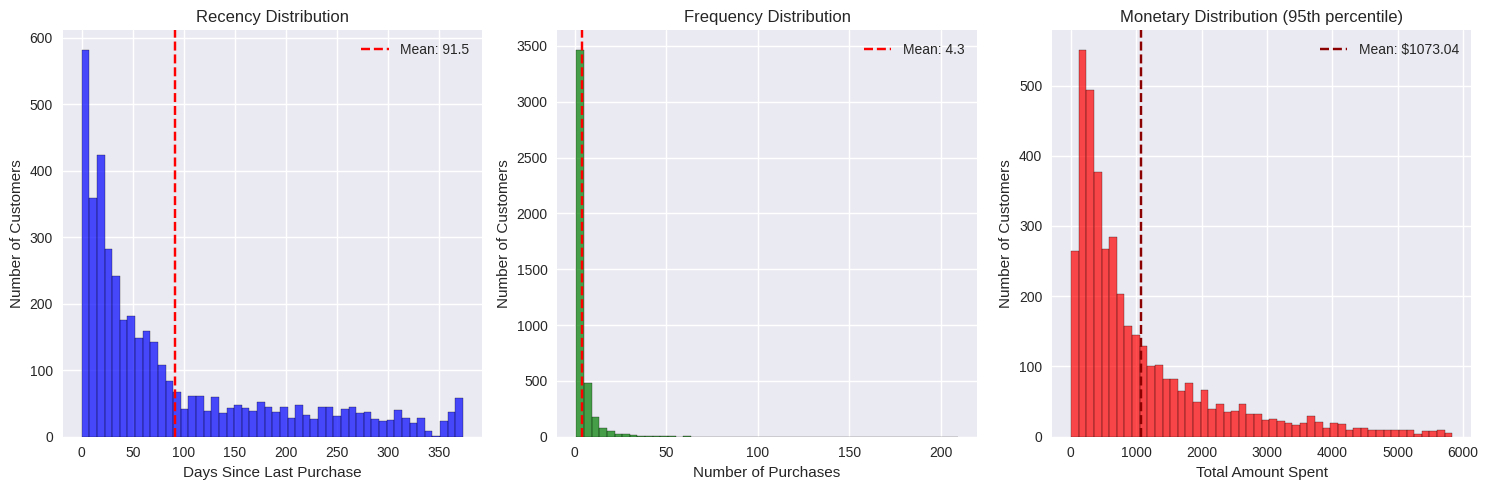

In [121]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(rfm_data['Recency'], bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.title('Recency Distribution')
plt.xlabel('Days Since Last Purchase')
plt.ylabel('Number of Customers')
plt.axvline(rfm_data['Recency'].mean(), color='red', linestyle='--', label=f'Mean: {rfm_data["Recency"].mean():.1f}')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(rfm_data['Frequency'], bins=50, color='green', alpha=0.7, edgecolor='black')
plt.title('Frequency Distribution')
plt.xlabel('Number of Purchases')
plt.ylabel('Number of Customers')
plt.axvline(rfm_data['Frequency'].mean(), color='red', linestyle='--', label=f'Mean: {rfm_data["Frequency"].mean():.1f}')
plt.legend()

plt.subplot(1, 3, 3)
# Use 95th percentile for better visualization
monetary_95th = rfm_data['Monetary'].quantile(0.95)
filtered_monetary = rfm_data[rfm_data['Monetary'] < monetary_95th]['Monetary']
plt.hist(filtered_monetary, bins=50, color='red', alpha=0.7, edgecolor='black')
plt.title('Monetary Distribution (95th percentile)')
plt.xlabel('Total Amount Spent')
plt.ylabel('Number of Customers')
plt.axvline(filtered_monetary.mean(), color='darkred', linestyle='--', label=f'Mean: ${filtered_monetary.mean():.2f}')
plt.legend()

plt.tight_layout()
plt.show()

#Insights

Recency:
- Min: 0 days (most recent buyers)
- Max: 373 days (nearly a year since last purchase)
- Customers <30 days: 1,694 (~39%)

Frequency:
- Min: 1
- Max: 209
- Mean: 4.3 orders/customer
- Customers with 5+ purchases: 1,114 (~26%)

Monetary:
- Min: 3.75
- Max: 280,206
- Mean: 2,054
- Customers spending 1,000+: 1,668 (~38%)

Distribution: Highly right-skewed (majority are occasional buyers, few high-value ‘loyalists’).


# 4. CUSTOMER SEGMENTATION USING CLUSTERING

In [122]:
print("\n Starting Customer Segmentation using K-Means Clustering...")
print("=" * 50)

# Prepare features for clustering
features = ['Recency', 'Frequency', 'Monetary']
X = rfm_data[features].copy()

print(f"Features for clustering: {features}")
print(f"Data shape before preprocessing: {X.shape}")

# Handle outliers using IQR method
print("\n Handling outliers using IQR method...")
for feature in features:
    Q1 = X[feature].quantile(0.25)
    Q3 = X[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print(f"   {feature}:")
    print(f"      Original range: {X[feature].min():.2f} to {X[feature].max():.2f}")
    print(f"      IQR bounds: {lower_bound:.2f} to {upper_bound:.2f}")

    # Clip outliers
    outliers_count = ((X[feature] < lower_bound) | (X[feature] > upper_bound)).sum()
    X[feature] = X[feature].clip(lower=lower_bound, upper=upper_bound)

    print(f"      Outliers clipped: {outliers_count}")
    print(f"      New range: {X[feature].min():.2f} to {X[feature].max():.2f}")

# Standardize the features
print("\n Standardizing features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"   Scaled data shape: {X_scaled.shape}")
print(f"   Mean of scaled features: {X_scaled.mean(axis=0)}")
print(f"   Std of scaled features: {X_scaled.std(axis=0)}")

# Find optimal number of clusters using Elbow method and Silhouette score
print("\n Finding optimal number of clusters...")

cluster_range = range(2, 11)
inertias = []
silhouette_scores = []

print("   Testing different cluster numbers...")
for k in cluster_range:
    print(f"      Testing k={k}...")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)

    inertia = kmeans.inertia_
    silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)

    inertias.append(inertia)
    silhouette_scores.append(silhouette_avg)

    print(f"         Inertia: {inertia:.2f}, Silhouette Score: {silhouette_avg:.3f}")



 Starting Customer Segmentation using K-Means Clustering...
Features for clustering: ['Recency', 'Frequency', 'Monetary']
Data shape before preprocessing: (4338, 3)

 Handling outliers using IQR method...
   Recency:
      Original range: 0.00 to 373.00
      IQR bounds: -169.00 to 327.00
      Outliers clipped: 155
      New range: 0.00 to 327.00
   Frequency:
      Original range: 1.00 to 209.00
      IQR bounds: -5.00 to 11.00
      Outliers clipped: 285
      New range: 1.00 to 11.00
   Monetary:
      Original range: 3.75 to 280206.02
      IQR bounds: -1724.07 to 3693.23
      Outliers clipped: 427
      New range: 3.75 to 3693.23

 Standardizing features...
   Scaled data shape: (4338, 3)
   Mean of scaled features: [7.04318526e-17 1.63795006e-18 7.20698026e-17]
   Std of scaled features: [1. 1. 1.]

 Finding optimal number of clusters...
   Testing different cluster numbers...
      Testing k=2...
         Inertia: 6282.21, Silhouette Score: 0.506
      Testing k=3...
        

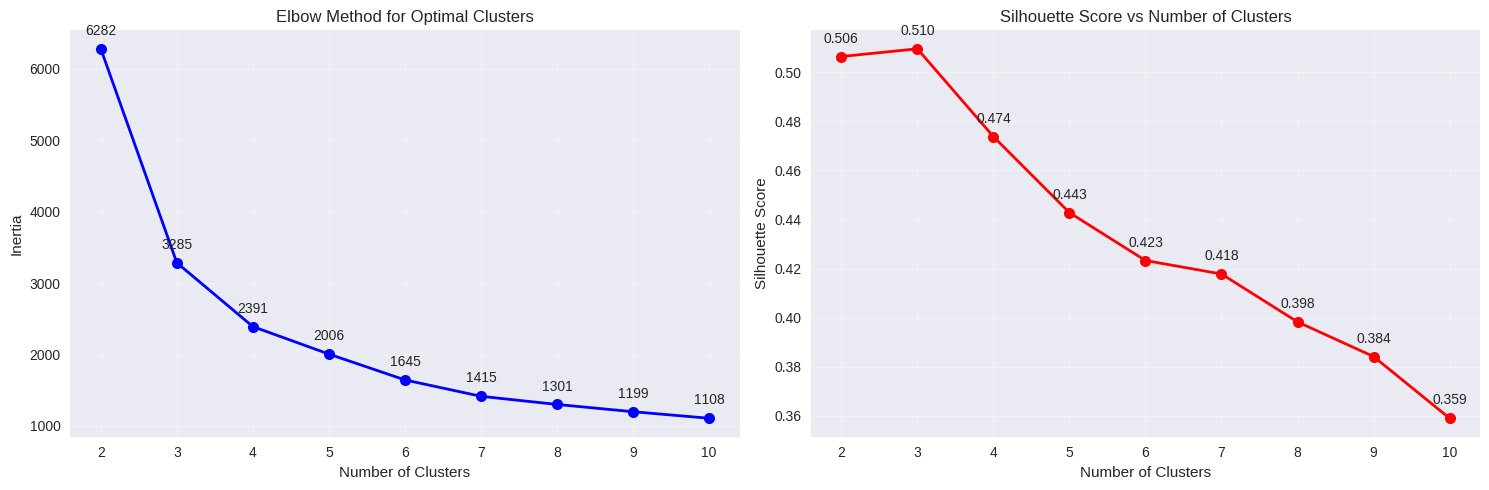

In [123]:
# Plot Elbow curve and Silhouette scores
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True, alpha=0.3)

# Add annotations
for i, (k, inertia) in enumerate(zip(cluster_range, inertias)):
    plt.annotate(f'{inertia:.0f}', (k, inertia), textcoords="offset points", xytext=(0,10), ha='center')

plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True, alpha=0.3)

# Add annotations
for i, (k, score) in enumerate(zip(cluster_range, silhouette_scores)):
    plt.annotate(f'{score:.3f}', (k, score), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

In [124]:
# Find optimal number of clusters (highest silhouette score)
optimal_clusters = cluster_range[np.argmax(silhouette_scores)]
best_silhouette_score = max(silhouette_scores)

print(f"\n Optimal number of clusters: {optimal_clusters}")
print(f" Best silhouette score: {best_silhouette_score:.3f}")


 Optimal number of clusters: 3
 Best silhouette score: 0.510


In [125]:
# Perform K-Means clustering with optimal number of clusters
print(f"\n Performing K-Means clustering with {optimal_clusters} clusters...")

kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to the dataframe
rfm_data['Cluster'] = cluster_labels

print(f"   Cluster assignment completed!")
print(f"   Cluster distribution:")
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
for cluster, count in cluster_counts.items():
    print(f"      Cluster {cluster}: {count:,} customers ({count/len(rfm_data)*100:.1f}%)")



 Performing K-Means clustering with 3 clusters...
   Cluster assignment completed!
   Cluster distribution:
      Cluster 0: 2,327 customers (53.6%)
      Cluster 1: 962 customers (22.2%)
      Cluster 2: 1,049 customers (24.2%)


In [126]:
# Calculate cluster statistics
cluster_stats = rfm_data.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).round(2)
cluster_stats.columns = ['Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Customer_Count']

print(f"\n Cluster Statistics:")
print("=" * 80)
print(cluster_stats)


 Cluster Statistics:
         Avg_Recency  Avg_Frequency  Avg_Monetary  Customer_Count
Cluster                                                          
0              47.97           2.46        731.49            2327
1              25.94          11.70       6949.77             962
2             248.32           1.47        499.10            1049


In [128]:
# Assign meaningful labels to clusters based on RFM characteristics
print(f"\n Assigning meaningful labels to clusters...")

# Calculate thresholds (median values across all clusters)
recency_threshold = cluster_stats['Avg_Recency'].median()
frequency_threshold = cluster_stats['Avg_Frequency'].median()
monetary_threshold = cluster_stats['Avg_Monetary'].median()

print(f"Thresholds for labeling:")
print(f"   Recency threshold: {recency_threshold:.1f} days")
print(f"   Frequency threshold: {frequency_threshold:.1f} purchases")
print(f"   Monetary threshold: ${monetary_threshold:.2f}")



 Assigning meaningful labels to clusters...
Thresholds for labeling:
   Recency threshold: 48.0 days
   Frequency threshold: 2.5 purchases
   Monetary threshold: $731.49


In [129]:
# Assign labels based on RFM characteristics
cluster_labels_map = {}

for cluster in cluster_stats.index:
    recency = cluster_stats.loc[cluster, 'Avg_Recency']
    frequency = cluster_stats.loc[cluster, 'Avg_Frequency']
    monetary = cluster_stats.loc[cluster, 'Avg_Monetary']

    # Assign labels based on RFM characteristics
    if frequency >= frequency_threshold and monetary >= monetary_threshold and recency <= recency_threshold:
        cluster_labels_map[cluster] = 'High-Value'
    elif frequency >= frequency_threshold/2 and monetary >= monetary_threshold/2:
        cluster_labels_map[cluster] = 'Regular'
    elif recency > recency_threshold * 1.5:
        cluster_labels_map[cluster] = 'At-Risk'
    else:
        cluster_labels_map[cluster] = 'Occasional'

print(f"\n Cluster labels assigned:")
for cluster, label in cluster_labels_map.items():
    print(f"   Cluster {cluster}: {label}")


 Cluster labels assigned:
   Cluster 0: High-Value
   Cluster 1: High-Value
   Cluster 2: Regular


In [130]:
# Apply segment labels to the dataframe
rfm_data['Segment'] = rfm_data['Cluster'].map(cluster_labels_map)

# Display segment distribution
print(f"\n Customer Segment Distribution:")
segment_counts = rfm_data['Segment'].value_counts()
for segment, count in segment_counts.items():
    print(f"   {segment}: {count:,} customers ({count/len(rfm_data)*100:.1f}%)")



 Customer Segment Distribution:
   High-Value: 3,289 customers (75.8%)
   Regular: 1,049 customers (24.2%)



 Creating cluster visualizations...


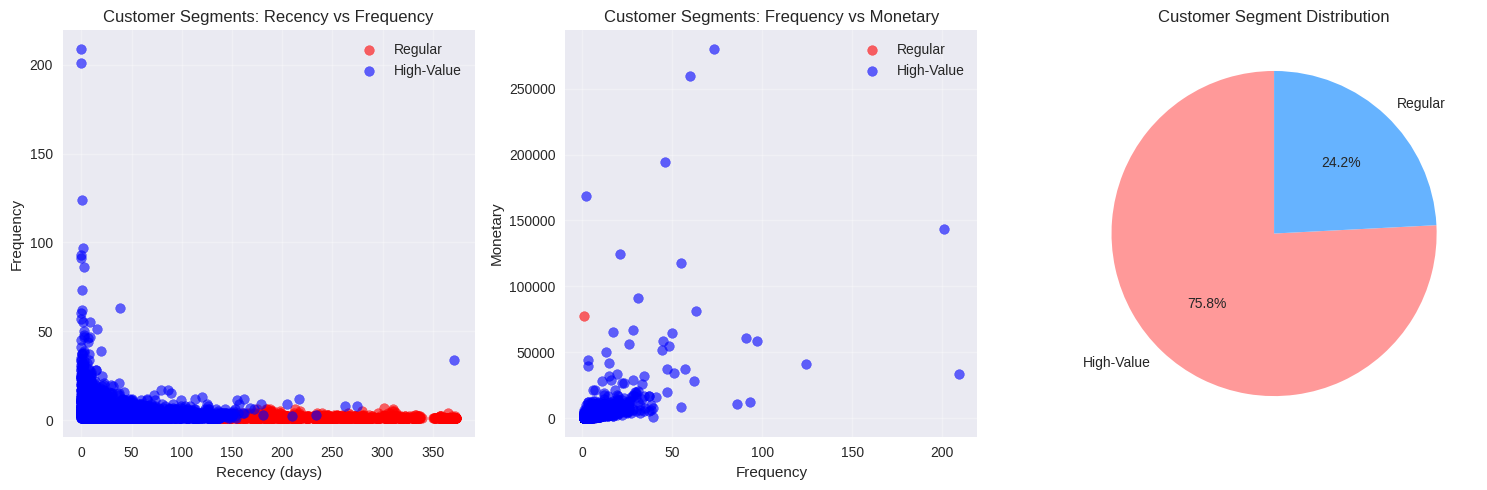

 Customer segmentation completed with 3 clusters!


In [133]:
# Visualize clusters
print(f"\n Creating cluster visualizations...")

fig = plt.figure(figsize=(15, 5))

# 2D scatter plot: Recency vs Frequency
plt.subplot(1, 3, 1)
colors = ['red', 'blue', 'green', 'orange', 'purple']
for i, segment in enumerate(rfm_data['Segment'].unique()):
    data = rfm_data[rfm_data['Segment'] == segment]
    plt.scatter(data['Recency'], data['Frequency'],
               label=segment, alpha=0.6, color=colors[i % len(colors)])
plt.xlabel('Recency (days)')
plt.ylabel('Frequency')
plt.title('Customer Segments: Recency vs Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

# 2D scatter plot: Frequency vs Monetary
plt.subplot(1, 3, 2)
for i, segment in enumerate(rfm_data['Segment'].unique()):
    data = rfm_data[rfm_data['Segment'] == segment]
    plt.scatter(data['Frequency'], data['Monetary'],
               label=segment, alpha=0.6, color=colors[i % len(colors)])
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.title('Customer Segments: Frequency vs Monetary')
plt.legend()
plt.grid(True, alpha=0.3)

# Pie chart: Segment distribution
plt.subplot(1, 3, 3)
segment_counts = rfm_data['Segment'].value_counts()
colors_pie = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
plt.pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%',
        colors=colors_pie, startangle=90)
plt.title('Customer Segment Distribution')

plt.tight_layout()
plt.show()

print(f" Customer segmentation completed with {optimal_clusters} clusters!")


# 5. PRODUCT RECOMMENDATION SYSTEM

In [136]:
print("\n Building Product Recommendation System...")
print("=" * 50)

# Create customer-product interaction matrix
print("1. Creating customer-product interaction matrix...")

customer_product_matrix = df_clean.pivot_table(
    index='CustomerID',
    columns='StockCode',
    values='Quantity',
    aggfunc='sum',
    fill_value=0
)

print(f"   Matrix shape: {customer_product_matrix.shape}")
print(f"   Total customers: {customer_product_matrix.shape[0]:,}")
print(f"   Total products: {customer_product_matrix.shape[1]:,}")
# Calculate sparsity
total_cells = customer_product_matrix.shape[0] * customer_product_matrix.shape[1]
zero_cells = (customer_product_matrix == 0).sum().sum()
sparsity = (zero_cells / total_cells) * 100
print(f"   Sparsity: {sparsity:.2f}%")
print(f"   Non-zero interactions: {total_cells - zero_cells:,}")



 Building Product Recommendation System...
1. Creating customer-product interaction matrix...
   Matrix shape: (4338, 3665)
   Total customers: 4,338
   Total products: 3,665
   Sparsity: 98.32%
   Non-zero interactions: 266,792


In [137]:
# Calculate item-item similarity using cosine similarity
print("\n2.  Calculating product similarity matrix...")

# Transpose to get product-customer matrix for item-based filtering
product_customer_matrix = customer_product_matrix.T
print(f"   Product-customer matrix shape: {product_customer_matrix.shape}")

# Calculate cosine similarity between products
print("   Computing cosine similarity (this may take a few minutes for large datasets)...")
similarity_matrix = cosine_similarity(product_customer_matrix)

print(f"   Similarity matrix shape: {similarity_matrix.shape}")
print(f"   Similarity calculation completed!")

# Create similarity dataframe with product codes as index and columns
similarity_df = pd.DataFrame(
    similarity_matrix,
    index=product_customer_matrix.index,
    columns=product_customer_matrix.index
)

print(f"   Similarity dataframe created with shape: {similarity_df.shape}")

# Create product name mapping (StockCode to Description)
product_names = df_clean.groupby('StockCode')['Description'].first().to_dict()
print(f"   Product names mapping created for {len(product_names)} products")

# Display sample similarities
print(f"\n Sample Product Similarities:")
sample_product = similarity_df.index[0]
sample_similarities = similarity_df[sample_product].sort_values(ascending=False).head(6)
print(f"   Products similar to '{product_names.get(sample_product, 'Unknown')}':")
for i, (product_code, similarity) in enumerate(sample_similarities.items(), 1):
    if product_code != sample_product:  # Skip the product itself
        product_name = product_names.get(product_code, 'Unknown Product')
        print(f"      {i-1}. {product_name} (Similarity: {similarity:.3f})")
    if i > 5:  # Show only top 5
        break

print(f"\n Recommendation system built with {len(product_names)} products!")



2.  Calculating product similarity matrix...
   Product-customer matrix shape: (3665, 4338)
   Computing cosine similarity (this may take a few minutes for large datasets)...
   Similarity matrix shape: (3665, 3665)
   Similarity calculation completed!
   Similarity dataframe created with shape: (3665, 3665)
   Product names mapping created for 3665 products

 Sample Product Similarities:
   Products similar to 'INFLATABLE POLITICAL GLOBE':
      1. MINI FUNKY DESIGN TAPES (Similarity: 0.854)
      2. CHERUB HEART DECORATION GOLD (Similarity: 0.713)
      3. CHRISTMAS TREE HANGING GOLD (Similarity: 0.699)
      4. BLACK/BLUE POLKADOT UMBRELLA (Similarity: 0.626)
      5. RED RETROSPOT CHILDRENS UMBRELLA (Similarity: 0.597)

 Recommendation system built with 3665 products!


In [138]:
# Test the recommendation system
print(f"\n Testing Recommendation System...")

# Function to get recommendations (inline implementation)
def get_recommendations_test(product_code, top_n=5):
    """Get product recommendations for testing"""
    if product_code not in similarity_df.index:
        return []

    # Get similarity scores for the product
    similar_products = similarity_df[product_code].sort_values(ascending=False)

    # Remove the product itself and get top N recommendations
    recommendations = []
    for code, score in similar_products.items():
        if code != product_code and len(recommendations) < top_n:
            product_name = product_names.get(code, 'Unknown Product')
            recommendations.append({
                'product_code': code,
                'product_name': product_name,
                'similarity_score': score
            })

    return recommendations



 Testing Recommendation System...


In [139]:
# Test with a few products
test_products = list(product_names.keys())[:3]
for test_product in test_products:
    product_name = product_names[test_product]
    recommendations = get_recommendations_test(test_product, top_n=3)

    print(f"\n    Recommendations for '{product_name}':")
    for i, rec in enumerate(recommendations, 1):
        print(f"      {i}. {rec['product_name']} (Score: {rec['similarity_score']:.3f})")



    Recommendations for 'INFLATABLE POLITICAL GLOBE':
      1. MINI FUNKY DESIGN TAPES (Score: 0.854)
      2. CHERUB HEART DECORATION GOLD (Score: 0.713)
      3. CHRISTMAS TREE HANGING GOLD (Score: 0.699)

    Recommendations for 'GROOVY CACTUS INFLATABLE':
      1. LARGE HEART MEASURING SPOONS (Score: 0.202)
      2. WRAP BAD HAIR DAY (Score: 0.175)
      3. WHITE GOOSE FEATHER CHRISTMAS TREE (Score: 0.172)

    Recommendations for 'DOGGY RUBBER':
      1. MUMMY MOUSE RED GINGHAM RIBBON (Score: 0.683)
      2. HAPPY BIRTHDAY CARD STRIPEY TEDDY (Score: 0.486)
      3. 3 BLACK CATS W HEARTS BLANK CARD (Score: 0.279)


#6. MODEL EVALUATION AND SAVING

In [140]:
print(f"\n Model Evaluation and Saving...")
print("=" * 50)

# Create models directory
os.makedirs('models', exist_ok=True)
print("   Created 'models' directory")

# Evaluate clustering model
print(f"\n Evaluating clustering model...")

# Prepare features for evaluation
features_for_eval = ['Recency', 'Frequency', 'Monetary']
X_for_eval = rfm_data[features_for_eval].copy()

# Handle outliers (same as before)
for feature in features_for_eval:
    Q1 = X_for_eval[feature].quantile(0.25)
    Q3 = X_for_eval[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    X_for_eval[feature] = X_for_eval[feature].clip(lower=lower_bound, upper=upper_bound)

# Scale features for evaluation
X_scaled_eval = scaler.transform(X_for_eval)

# Calculate evaluation metrics
silhouette_avg = silhouette_score(X_scaled_eval, rfm_data['Cluster'])
inertia = kmeans.inertia_

print(f"    Clustering Model Performance:")
print(f"      Silhouette Score: {silhouette_avg:.3f}")
print(f"      Inertia: {inertia:.2f}")
print(f"      Number of clusters: {kmeans.n_clusters}")
print(f"      Algorithm: {kmeans.__class__.__name__}")

# Evaluate recommendation system
print(f"\n    Recommendation System Performance:")
print(f"      Total products in system: {len(product_names):,}")
print(f"      Similarity matrix size: {similarity_df.shape}")
print(f"      Coverage: {len(product_names)/df_clean['StockCode'].nunique()*100:.1f}% of products")
print(f"      Average similarity score: {similarity_matrix.mean():.3f}")



 Model Evaluation and Saving...
   Created 'models' directory

 Evaluating clustering model...
    Clustering Model Performance:
      Silhouette Score: 0.510
      Inertia: 3285.41
      Number of clusters: 3
      Algorithm: KMeans

    Recommendation System Performance:
      Total products in system: 3,665
      Similarity matrix size: (3665, 3665)
      Coverage: 100.0% of products
      Average similarity score: 0.036


# Save clustering models

In [141]:
print(f"\n Saving clustering models...")

try:
    joblib.dump(scaler, 'models/rfm_scaler.pkl')
    print("    Saved: rfm_scaler.pkl")

    joblib.dump(kmeans, 'models/kmeans_model.pkl')
    print("   Saved: kmeans_model.pkl")

    # Save cluster label mapping
    cluster_labels_dict = rfm_data.groupby('Cluster')['Segment'].first().to_dict()
    joblib.dump(cluster_labels_dict, 'models/cluster_labels.pkl')
    print("    Saved: cluster_labels.pkl")
    print(f"      Cluster labels: {cluster_labels_dict}")

except Exception as e:
    print(f"    Error saving clustering models: {e}")


 Saving clustering models...
    Saved: rfm_scaler.pkl
   Saved: kmeans_model.pkl
    Saved: cluster_labels.pkl
      Cluster labels: {0: 'High-Value', 1: 'High-Value', 2: 'Regular'}


#Save Recommendation System

In [142]:
# Save recommendation system components
print(f"\n Saving recommendation system...")

try:
    joblib.dump(similarity_df, 'models/similarity_matrix.pkl')
    print("    Saved: similarity_matrix.pkl")
    print(f"      Matrix size: {similarity_df.shape}")

    joblib.dump(product_names, 'models/product_names.pkl')
    print("    Saved: product_names.pkl")
    print(f"      Product names: {len(product_names)} products")

except Exception as e:
    print(f"    Error saving recommendation system: {e}")


 Saving recommendation system...
    Saved: similarity_matrix.pkl
      Matrix size: (3665, 3665)
    Saved: product_names.pkl
      Product names: 3665 products


In [143]:
# Save sample data for testing Streamlit app
print(f"\n Saving sample data for Streamlit app...")

try:
    # Save sample RFM data (first 100 customers)
    sample_rfm = rfm_data.head(100).copy()
    sample_rfm.to_csv('models/sample_rfm_data.csv', index=False)
    print("    Saved: sample_rfm_data.csv")
    print(f"      Sample size: {len(sample_rfm)} customers")

    # Save segment distribution for reference
    segment_distribution = rfm_data['Segment'].value_counts().to_dict()
    joblib.dump(segment_distribution, 'models/segment_distribution.pkl')
    print("    Saved: segment_distribution.pkl")
    print(f"      Segments: {list(segment_distribution.keys())}")

except Exception as e:
    print(f"    Error saving sample data: {e}")



 Saving sample data for Streamlit app...
    Saved: sample_rfm_data.csv
      Sample size: 100 customers
    Saved: segment_distribution.pkl
      Segments: ['High-Value', 'Regular']


In [144]:
# Create a summary file with key information
print(f"\n Creating model summary file...")

try:
    summary_info = {
        'model_creation_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'dataset_info': {
            'original_rows': len(df),
            'cleaned_rows': len(df_clean),
            'customers': df_clean['CustomerID'].nunique(),
            'products': df_clean['StockCode'].nunique(),
            'countries': df_clean['Country'].nunique(),
            'date_range': f"{df_clean['InvoiceDate'].min()} to {df_clean['InvoiceDate'].max()}",
            'total_revenue': float(df_clean['TotalAmount'].sum())
        },
        'clustering_model': {
            'algorithm': 'KMeans',
            'n_clusters': int(kmeans.n_clusters),
            'silhouette_score': float(silhouette_avg),
            'inertia': float(inertia),
            'segments': cluster_labels_dict
        },
        'recommendation_system': {
            'method': 'Item-based Collaborative Filtering',
            'similarity_metric': 'Cosine Similarity',
            'products_count': len(product_names),
            'matrix_sparsity': float(sparsity)
        },
        'rfm_statistics': {
            'recency_mean': float(rfm_data['Recency'].mean()),
            'frequency_mean': float(rfm_data['Frequency'].mean()),
            'monetary_mean': float(rfm_data['Monetary'].mean())
        }
    }

    joblib.dump(summary_info, 'models/model_summary.pkl')
    print("    Saved: model_summary.pkl")

except Exception as e:
    print(f"    Error creating summary file: {e}")

print(f"\n All models and data saved successfully!")



 Creating model summary file...
    Saved: model_summary.pkl

 All models and data saved successfully!


# Conclusion

This project effectively combines customer segmentation and product recommendations to create a complete customer intelligence solution for retail data. By using RFM features and KMeans clustering, we successfully categorized customers into three well-defined segments, each representing a unique level of customer engagement and value to the business.
These segments can directly inform targeted business strategies:

- Loyal customers (Cluster 0) can be rewarded through exclusive offers, loyalty programs, or early access to new products.
- At-risk customers (Cluster 1) can be re-engaged through reminder emails, discounts, or satisfaction surveys.
- Potential loyalists (Cluster 2) may benefit from onboarding offers, tailored content, and upsell campaigns to increase their engagement.

The integrated item-based recommendation system adds a personalized touch by suggesting similar products that customers are likely to be interested in. This system can increase basket size, encourage repeat purchases, and improve the overall customer experience.

Together, these tools provide a strong foundation for building a data-driven CRM (Customer Relationship Management) and retail analytics platform, empowering the business to move from generic, one-size-fits-all marketing to personalized, insight-driven decision-making. Future enhancements may include real-time segmentation, hybrid recommendation models, or integration into a customer-facing app or dashboard.
